# Error Bar Illustration

In [1]:
from datetime import datetime
from matplotlib import dates as mdates
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skewnorm

sns.set()

In [2]:
time_range = (pd.Timestamp("2010-05-13 0:00:00"), pd.Timestamp("2010-06-01 00:00:00"))

In [3]:
# Read from Disk
df_dataset = pd.read_csv(
    #    "../data/processed/skew_gaussian/k200/delta_window8/processed_daysahead3_R000.csv"
    # "../data/processed/test/processed_daysahead3_R000.csv"
    "../data/processed/rfr/processed_daysahead3_R000.csv"
)
df_dataset.forward_time = pd.to_datetime(df_dataset.forward_time)

# Subset
df_dataset = df_dataset[df_dataset.forward_time.between(*time_range)]

# Print
df_dataset.head()

,current_time,forward_time,forward_Vp_pred,forward_Vp_obs,forward_loc,forward_scale,forward_shape,forward_crps
504,2010-05-10 06:00:00,2010-05-13 00:00:00,475.233333,448.28,334.403396,139.204723,2.755015,23.005288
505,2010-05-10 12:00:00,2010-05-13 06:00:00,454.033333,414.89,323.721470,133.915371,2.444057,20.741573
506,2010-05-10 18:00:00,2010-05-13 12:00:00,438.600000,380.22,301.096123,143.470518,2.983405,22.830334
507,2010-05-11 00:00:00,2010-05-13 18:00:00,422.000000,380.81,298.211585,148.787839,2.643999,23.985949
508,2010-05-11 06:00:00,2010-05-14 00:00:00,406.100000,358.60,293.963428,155.111432,3.280912,29.719596


In [4]:
err1 = []
err2 = []
median = []
pdf = []
bins = np.arange(200, 801)

for _, row in df_dataset.iterrows():
    dist = skewnorm(
        row.forward_shape,
        loc=row.forward_loc,
        scale=row.forward_scale,
    )
    err1.append(dist.interval(0.75))
    err2.append(dist.interval(0.95))
    median.append(dist.interval(0)[0])
    pdf.append(dist.pdf(bins))


err1 = np.array(err1)
err2 = np.array(err2)
median = np.array(median)
err1.shape

(77, 2)

In [5]:
delta = df_dataset.forward_shape / np.sqrt(1 + df_dataset.forward_shape**2)
dist_mean = df_dataset.forward_loc + df_dataset.forward_scale * delta * np.sqrt(
    2 / np.pi
)

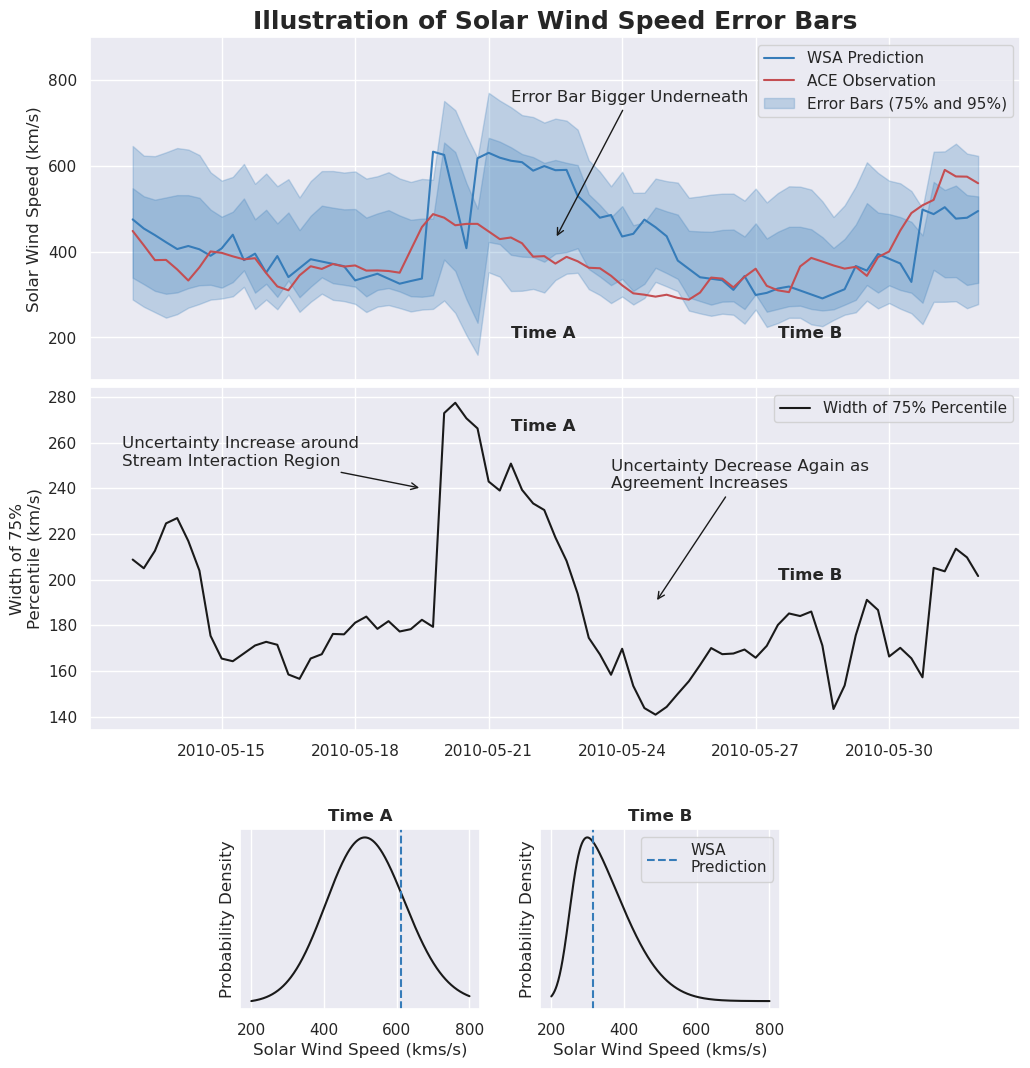

In [6]:
blue_color = "#367cb9"
red_color = "r"
black_color = "k"
gold_color = "orange"
purple_color = "purple"
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 9))

# Error Bars ------------------------------
ax = axes[0]
ax.plot(
    df_dataset["forward_time"],
    df_dataset["forward_Vp_pred"],
    color=blue_color,
    label="WSA Prediction",
)
ax.plot(
    df_dataset["forward_time"],
    df_dataset["forward_Vp_obs"],
    color=red_color,
    label="ACE Observation",
)
ax.fill_between(
    df_dataset["forward_time"],
    err1[:, 0],
    err1[:, 1],
    alpha=0.25,
    color=blue_color,
    label="Error Bars (75% and 95%)",
)
ax.fill_between(
    df_dataset["forward_time"], err2[:, 0], err2[:, 1], alpha=0.25, color=blue_color
)
ax.set_ylabel("Solar Wind Speed (km/s)")
ax.set_yticks([200, 400, 600, 800])
ax.set_ylim(100, 900)

ax.annotate(
    "Error Bar Bigger Underneath",
    xytext=(pd.Timestamp("2010-05-21 12:00:00"), 750),
    xy=(pd.Timestamp("2010-05-22 12:00:00"), 430),
    arrowprops=dict(arrowstyle="->", color="k"),
)

# Scale Parameter ------------------------------
ax = axes[1]
ax.plot(
    df_dataset["forward_time"],
    err1[:, 1] - err1[:, 0],
    color=black_color,
    label="Width of 75% Percentile",
)
ax.set_ylabel("Width of 75%\nPercentile (km/s)")

ax.annotate(
    "Uncertainty Increase around\nStream Interaction Region",
    xytext=(pd.Timestamp("2010-05-12 18:00:00"), 250),
    xy=(pd.Timestamp("2010-05-19 12:00:00"), 240),
    arrowprops=dict(arrowstyle="->", color="k"),
)

ax.annotate(
    "Uncertainty Decrease Again as\nAgreement Increases",
    xytext=(pd.Timestamp("2010-05-23 18:00:00"), 240),
    xy=(pd.Timestamp("2010-05-24 18:00:00"), 190),
    arrowprops=dict(arrowstyle="->", color="k"),
)

# ax= axes[3]
# [left, bottom, width, height]
ax = fig.add_axes([0.25, -0.2, 0.2, 0.2])
t = pd.Timestamp("2010-05-21 12:00:00")
axes[0].text(t, 200, "Time A", fontweight="bold")
axes[1].text(t, 265, "Time A", fontweight="bold")
ax.set_title("Time A", fontweight="bold")
i = df_dataset.forward_time.searchsorted(t)
ax.plot(bins, pdf[i], "k")
ax.axvline(df_dataset.forward_Vp_pred.iloc[i], linestyle="dashed", color=blue_color)
ax.set_yticks([])
ax.set_ylabel("Probability Density")
ax.set_xlabel("Solar Wind Speed (kms/s)")

ax = fig.add_axes([0.5, -0.2, 0.2, 0.2])
t = pd.Timestamp("2010-05-27 12:00:00")
axes[0].text(t, 200, "Time B", fontweight="bold")
axes[1].text(t, 200, "Time B", fontweight="bold")
ax.set_title("Time B", fontweight="bold")
i = df_dataset.forward_time.searchsorted(t)
ax.plot(bins, pdf[i], "k")
ax.axvline(
    df_dataset.forward_Vp_pred.iloc[i],
    linestyle="dashed",
    color=blue_color,
    label="WSA\nPrediction",
)
ax.set_ylabel("Probability Density")
ax.set_yticks([])
ax.set_xlabel("Solar Wind Speed (kms/s)")
ax.legend()


# Shape Parameter ------------------------------
# ax = axes[3]
# ax.plot(
#    df_dataset["forward_time"],
#    df_dataset["forward_shape"],
#    color=gold_color,
#    label=r"Distribution Shape Parameter ($\alpha$)' + '\n(Controls Skewness)",
# )
# ax.set_ylabel("Distribution Shape\nParameter")
# ax.axhline(0, linestyle="dashed", color="k")
# ax.text(pd.Timestamp("2010-05-13 22:00:00"), 0.75, "Skewed Above")
# ax.text(pd.Timestamp("2010-05-13 22:00:00"), -0.75, "Skewed Below")

for ax in axes:
    ax.legend(loc="upper right")

# i = 500
# print(repr((df_dataset.index[i], df_dataset.index[i + 100])))
#    ax.set_xlim(df_dataset.index[i], df_dataset.index[i + 100])

# plt.xlim(pd.Timestamp('2010-02-25 18:00:00'), pd.Timestamp('2010-03-22 18:00:00'))
axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=3))
axes[0].set_title(
    "Illustration of Solar Wind Speed Error Bars", fontweight="bold", fontsize=18
)
plt.subplots_adjust(wspace=0.4, hspace=0.02)


plt.savefig("../plots/error_bar_illustration.png", dpi=300, bbox_inches="tight")

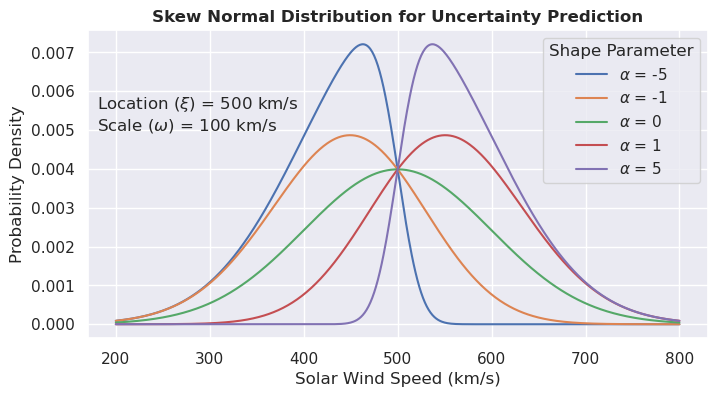

In [7]:
plt.figure(figsize=(8, 4))

bins = np.arange(200, 801, 1)

for skew in [-5, -1, 0, 1, 5]:
    dist = skewnorm(
        skew,
        loc=500,
        scale=100,
    )
    plt.plot(bins, dist.pdf(bins), label=r"$\alpha$ = " + f"{skew}")

plt.xlabel("Solar Wind Speed (km/s)")
plt.ylabel("Probability Density")
plt.legend().set_title("Shape Parameter")
plt.title("Skew Normal Distribution for Uncertainty Prediction", fontweight="bold")
plt.text(
    180, 0.005, r"Location ($\xi$) = 500 km/s" + "\n" + "Scale ($\omega$) = 100 km/s"
)
plt.savefig("../plots/skewnormal.png", bbox_inches="tight", dpi=300)